In [84]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from numpy import eye
import Analysis
%matplotlib inline

In [85]:
df = pd.read_csv('cs-training.csv', header=0)
df.reset_index()
df = df.rename(columns={'Unnamed: 0':'ID', 
                        'NumberOfTime30-59DaysPastDueNotWorse':'Less2months',
                       'NumberOfTimes90DaysLate':'More3months',
                       'NumberOfTime60-89DaysPastDueNotWorse':'Less3months'})
df = df.set_index('ID')
df = df.fillna(df.mean())
x_train = df.iloc[:, 1:]

In [86]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
sc.fit(x_train)
x_train_std = sc.transform(x_train)
x_train_std = pd.DataFrame(x_train_std)
x_train_std.index = x_train_std.index + 1
x_train_std.columns = df.iloc[:, 1:].columns

#new_df = pd.concat([df.iloc[:, 0], df_std], axis=1)

In [55]:
#df['Age_bin'] = pd.cut(df.iloc[:, 2], 4, labels=False)
#dummy_df = pd.get_dummies(df['Age_bin'], drop_first=True).rename(columns={1:'Age_1', 
#                                                                2:'Age_2',
#                                                                3:'Age_3'})

y_train = df.iloc[:, 0]

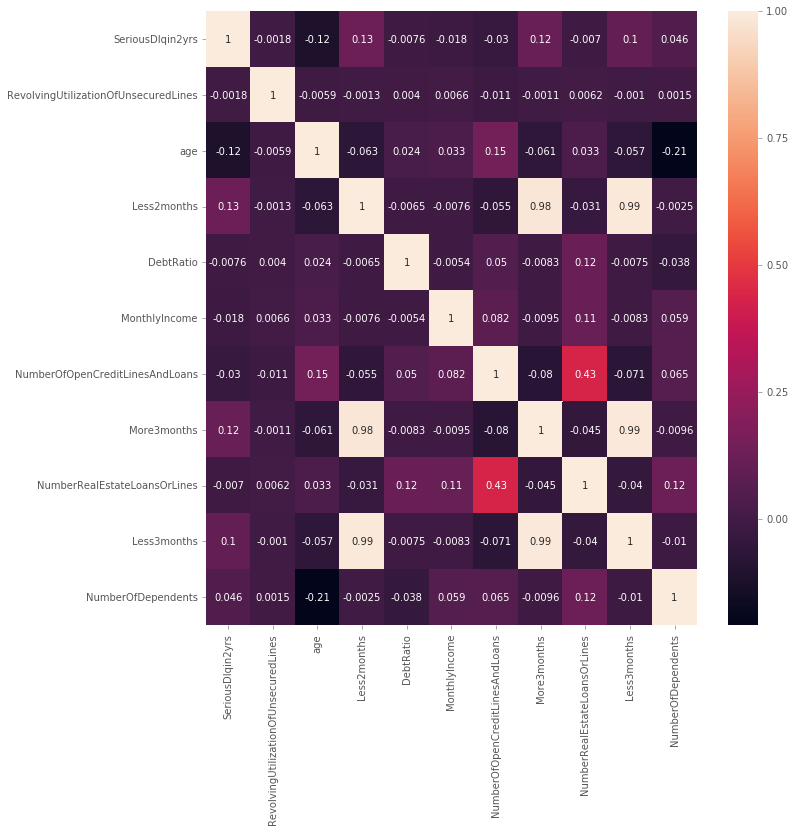

In [64]:
plt.figure(figsize=(11,11))
sns.heatmap(df.corr(), annot=True)

In [67]:
from sklearn.ensemble import RandomForestClassifier
forest = RandomForestClassifier(min_samples_leaf=4, random_state=0)
forest.fit(x_train, y_train)
print('Train score: {}'.format(forest.score(x_train, y_train)))

Train score: 0.9555666666666667


([<matplotlib.axis.YTick at 0x7f0b0b8606a0>,
 <a list of 10 Text yticklabel objects>)

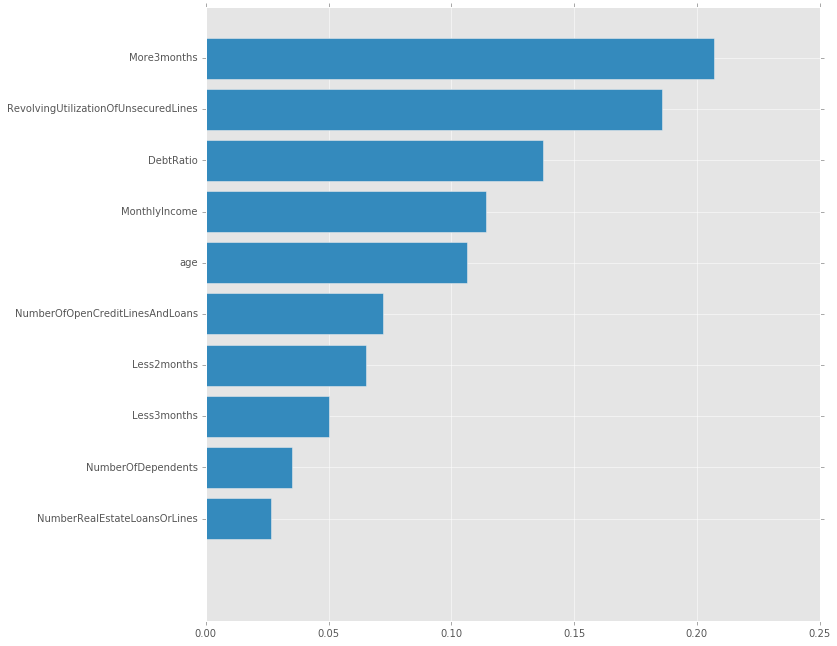

In [71]:
values, names = zip(*sorted(zip(forest.feature_importances_, x_train.columns)))

plt.figure(figsize=(11,11))
plt.barh(range(len(names)), values, align='center')
plt.yticks(range(len(names)), names)

In [75]:
from sklearn.metrics import make_scorer
from sklearn.metrics import f1_score
from sklearn.model_selection import GridSearchCV
# ハイパーパラメータ
forest_grid_param = {
    'n_estimators': [100],
    'max_features': [1, 'auto', None],
    'max_depth': [1, 5, 10, None],
    'min_samples_leaf': [1, 2, 4,]
}

# スコア方法をF1に設定
f1_scoring = make_scorer(f1_score,  pos_label=1)

# グリッドサーチで学習
forest_grid_search = GridSearchCV(RandomForestClassifier(random_state=0, n_jobs=-1), forest_grid_param, scoring=f1_scoring, cv=4)
forest_grid_search.fit(x_train, y_train)

# 結果
print('Best parameters: {}'.format(forest_grid_search.best_params_))
print('Best score: {:.3f}'.format(forest_grid_search.best_score_))

/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-sco

KeyboardInterrupt: 

In [56]:
from sklearn.linear_model import LogisticRegressionCV
logistic = LogisticRegressionCV(cv=10, random_state=0)
logistic.fit(x_train_std, y_train)

# 検証
print('Train score: {:.3f}'.format(logistic.score(x_train_std, y_train)))

Train score: 0.934


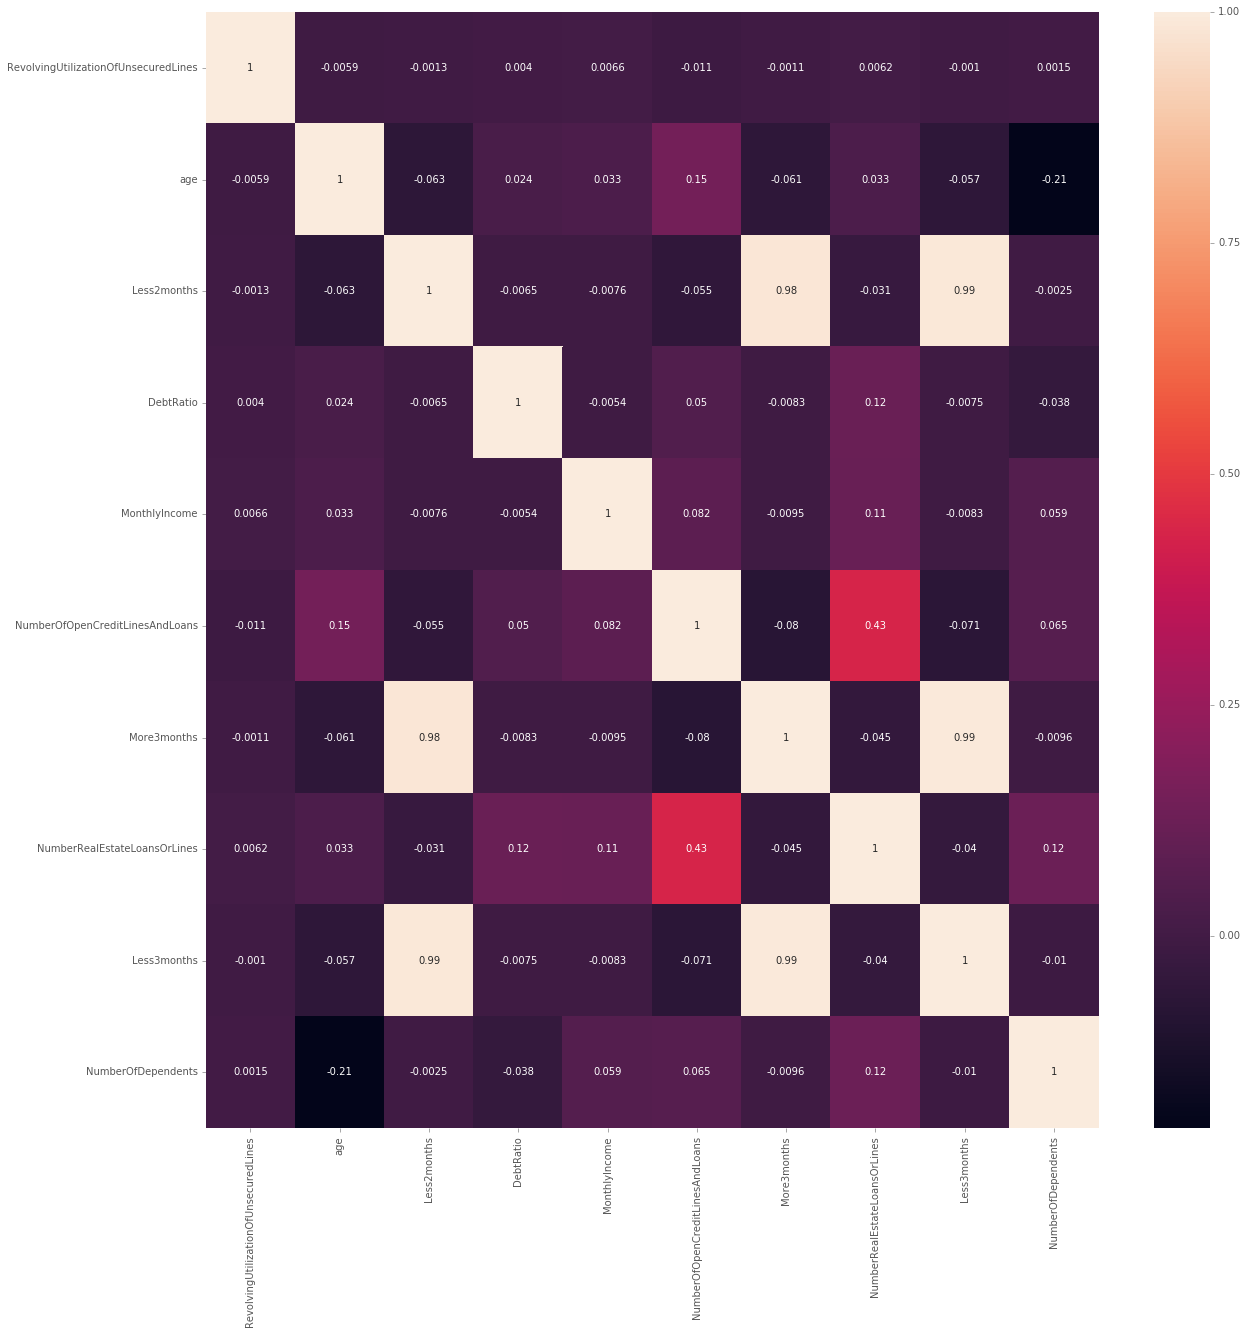

In [57]:
plt.figure(figsize=(20, 20))
sns.heatmap(pd.DataFrame(x_train_std).corr(), annot=True)

<Container object of 10 artists>

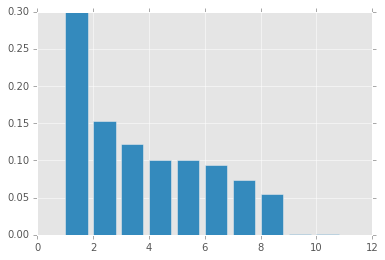

In [58]:
from sklearn.decomposition import PCA
pca = PCA(n_components=10)
pca.fit(x_train_std)
plt.bar([n for n in range(1, len(pca.explained_variance_ratio_)+1)], pca.explained_variance_ratio_)

x_train_std: (150000, 5)
explained variance ratio: [ 0.29948872  0.1533157   0.12254696  0.10092078  0.10010863]


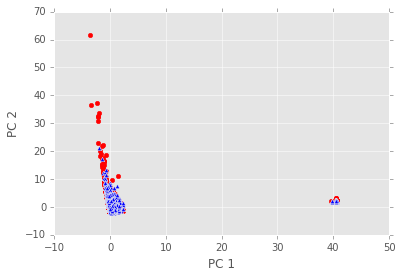

In [61]:
pca = PCA(n_components=5)
x_train_pca = pca.fit_transform(x_train_std)
print('x_train_std: {}'.format(x_train_pca.shape))

# 寄与率
print('explained variance ratio: {}'.format(pca.explained_variance_ratio_))
# explained variance ratio: [ 0.43315126  0.19586506]

# 散布図にプロット
temp = pd.DataFrame(x_train_pca)
temp['Outcome'] = y_train.values
b = temp[temp['Outcome'] == 0]
m = temp[temp['Outcome'] == 1]
plt.scatter(x=b[0], y=b[1], marker='o', color='red') # 良性は○でマーク
plt.scatter(x=m[0], y=m[1], marker='^') # 悪性は△でマーク
plt.xlabel('PC 1') # 第1主成分をx軸
plt.ylabel('PC 2') # 第2主成分をy軸

In [43]:
from sklearn.pipeline import Pipeline
pca_pipeline = Pipeline([
    ('scale', StandardScaler()),
    ('decomposition', PCA(n_components=5)),
    ('model', LogisticRegressionCV(cv=10, random_state=0))
])

# 標準化・次元圧縮・学習
pca_pipeline.fit(x_train, y_train)

# 検証
print('Train score: {:.3f}'.format(pca_pipeline.score(x_train, y_train)))
#print('Test score: {:.3f}'.format(pca_pipeline.score(X_test, y_test)))
#print('Confustion matrix:\n{}'.format(confusion_matrix(y_true=y_test, y_pred=pca_pipeline.predict(X_test))))

NameError: name 'LogisticRegressionCV' is not defined

In [89]:
from sklearn.tree import DecisionTreeClassifier
tree = DecisionTreeClassifier(criterion='gini', max_depth=5,random_state=0)
tree.fit(x_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=0,
            splitter='best')

In [92]:
import pydotplus
from sklearn.externals.six import StringIO
dot_data = StringIO()
tree.export_graphviz(clf, out_file=dot_data)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
from IPython.display import Image
Image(graph.create_png())

ImportError: No module named 'pydotplus'

In [88]:
from mlxtend.plotting import plot_decision_regions
#plt.style.use('ggplot') 

X_combined_std = np.vstack((x_train_std))
y_combined = np.hstack((y_train))

fig = plt.figure(figsize=(13,8))
plot_decision_regions(X_combined_std, y_combined, clf=tree)
plt.show()

ValueError: X must be an integer or float array. Found <U36.

In [ ]:
from sklearn.svm import SVC
svm = SVC(kernel='linear', C=1.0,random_state=None)
svm.fit(x_train_std, y_train)

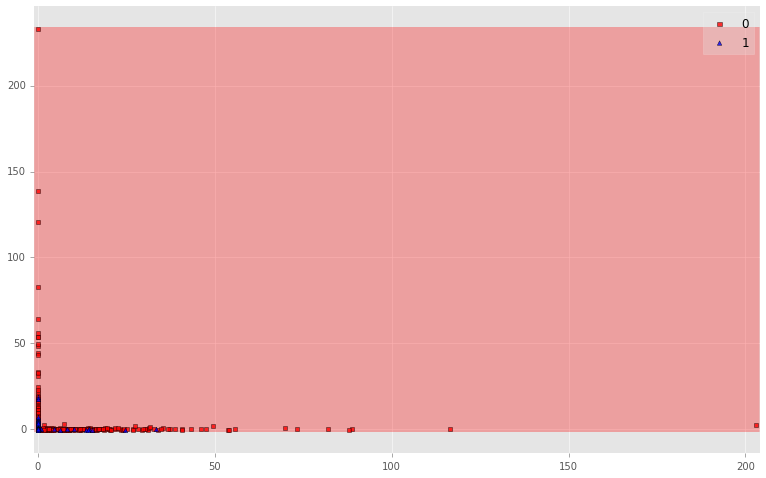

In [10]:
from mlxtend.plotting import plot_decision_regions
plt.style.use('ggplot') 

X_combined_std = np.vstack((x_train_std))
y_combined = np.hstack((y_train))

fig = plt.figure(figsize=(13,8))
plot_decision_regions(X_combined_std, y_combined, clf=svm,  res=0.02)
plt.show()

In [10]:
from sklearn.metrics import accuracy_score

# トレーニングデータに対する精度
pred_train = tree.predict(x_train_std)
accuracy_train = accuracy_score(y_train, pred_train)
print('トレーニングデータに対する正解率： %.2f' % accuracy_train)

トレーニングデータに対する正解率： 0.93


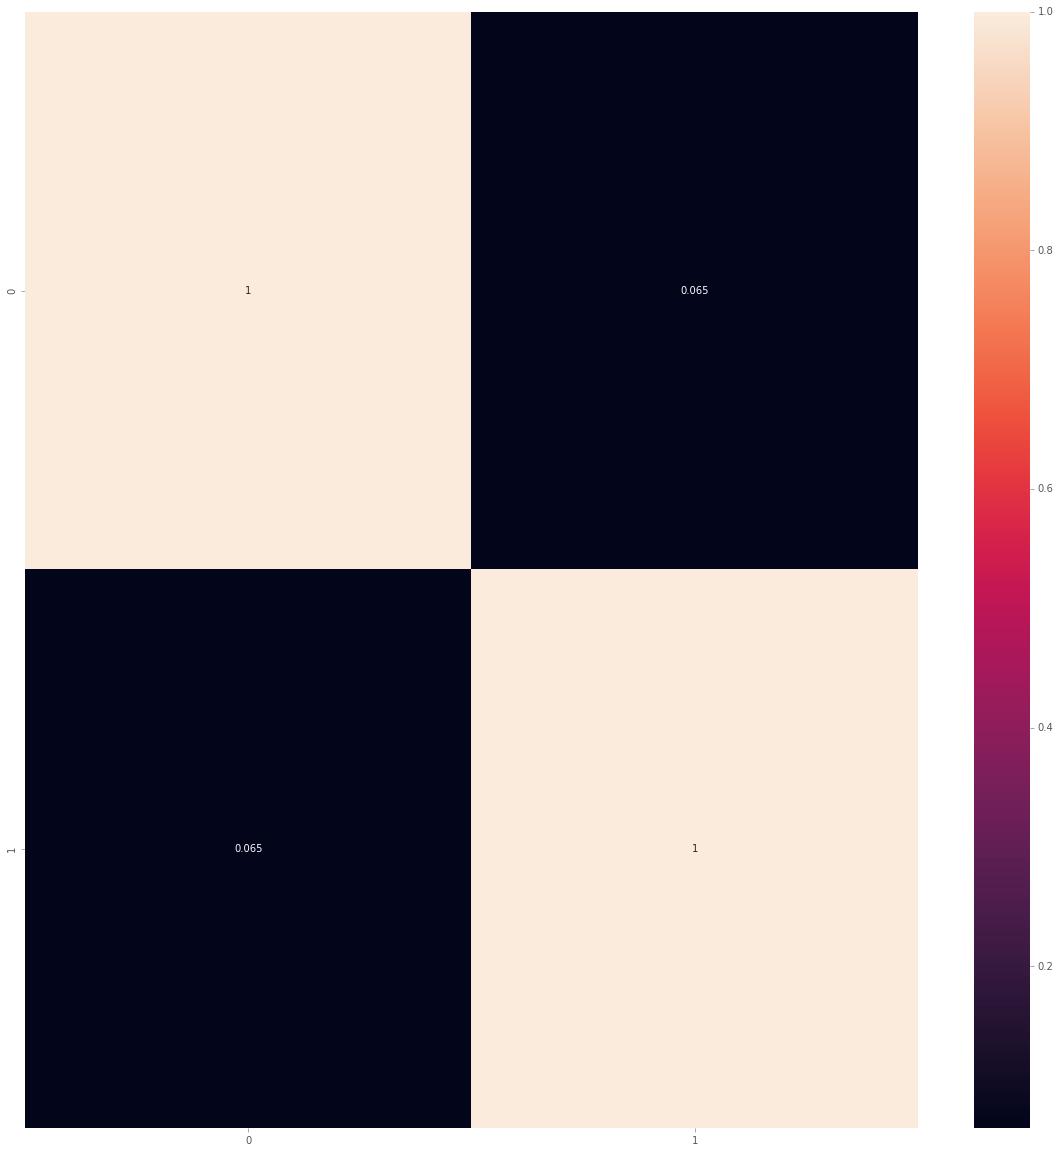

In [12]:
plt.figure(figsize=(20, 20))
sns.heatmap(pd.DataFrame(x_train_std).corr(), annot=True)